# Pulling from the Community Crime Map

In order to extract incident data for certain geographies (e.g., Las Cruces, NM), this document highlights how to wrap a couple end points for the Lexis Nexis Community Crime Map to programmatically request data from the [site](https://communitycrimemap.com/). 

First, a bit of house keeping. The data on the Community Crime Map is provided by LE agencies. For example, in the case of Las Cruces, NM, LCPD states that ["LCPD offers a Community Crime Map that is updated regularly and indicates approximate locations of property crimes reported within city limits. The type of crime, date, and approximate time and location are included along with a report number"](https://www.lascruces.gov/2181/LCPD-Transparency). The spatial data in the community crime map has been randomly transformed and the addresses partially masked in order to protect victim privacy. Thus, spatial data are not accurate and should not be used at face value. However, the partially masked addresses include zip codes, which can be used to generate aggregates. 

In addition to the data limitations, there are service limitations. For one, the data endpoints return at most 500 incidents per query. Thus, queries need to be broken down into smaller subsets, both temporally and spatially, in order to avoid hitting a rate limit. In this implementation, I pull data on a weekly basis with a bounding box that includes Las Cruces. Second, in order to create a request, a bearer token is required. Here, I implement a session and cache the token.

In [144]:
# Import required tools
from datetime import date, timedelta, datetime
import json
import matplotlib.pyplot as plt
import pandas as pd
import re
import requests

Set up support functions. These are tools that will enable:

- Splitting a year into weekly periods, used to create discrete time boundaries.
- Group incidents event into daily counts, used to plot the distribution of events in the data.

In [146]:
def split_year_into_weeks(year: int) -> dict:
    """
    Yearly week splitter
    -------------------
    A bespoke function to take a year and split it into weeks.
    
    Parameters
    ----------
    year: int
        A integer representing a year, it must be four digits.

    Returns
    -------
    dict
        A dictionary were keys represent week numbers (e.g., 1-...) and the 
        values are lists containing the dates within that week.

    """
    assert isinstance(year, int) and year > 0, "year must be a positive integer."
    weeks = {}
    counter = 1
    start_date = date(year, 1, 1)
    end_date = date(year + 1, 1, 1)

    # Find the first Monday of the year
    current_date = start_date

    while current_date < end_date:
        week_dates = [(current_date + timedelta(days=i)).strftime("%m/%d/%Y") for i in range(7)]
        weeks[counter] = week_dates
        current_date += timedelta(weeks=1)
        counter += 1

    return weeks

def group_by_day(df: pd.DataFrame, day_var: str) -> None:
    """
    Group and Count by Day
    ----------------------
    Group events by day and count number of incidents.

    Parameters
    ----------
    df: pandas.DataFrame
        A pandas dataframe of incidents.
    day_var: str
        A string denoting the variable that contains dates.
    """
    df['date'] = pd.to_datetime(df[day_var])
    out = df.groupby(df['date'].dt.date).size().reset_index(name='dcount')
    return(out)

Set up main data fetching function. Here, the function calls the Community Crime Map endpoint seeking weekly cuts.

In [4]:
def get_weekly_crime_cuts(year: int, headers: dict = None, data: dict = None, 
                          verbose: bool = False, tidy: bool = False) -> dict:
    """
    
    """
    assert 2015 <= year < 2021, "year must be a number between 2015 and 2021."

    if data is not None: 
        assert len([key for key in ["buffer", "agencies", "layers", "location", "analyticLayers"] if key not in data]) ==  0, "data argument must be dictionary with specific keys, see documentation."
    elif data is None:
        data = {
            "buffer":{"enabled":False,"restrictArea":False,"value":[]},
            "agencies":[],
            "layers":{"selection":[None,None,{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,{"selected":False},None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True},{"selected":True}]},
            "location":{"bounds":{"east":-105.43018090401888,"north":32.55434984788866,"south":32.00401261328501,"west":-108.05591332589388},"lat":32.279181230586836,"lng":-106.74304711495638,"zoom":9},
            "analyticLayers":{"density":{"selected":False,"transparency":60}}
                }
        
    if headers is None:
        headers = {}
        
    # Set up session and access token
    session = requests.Session()
    session.get('https://communitycrimemap.com/api/v1/auth/newToken')
    if verbose:
        print(f"Working with token: {session.cookies['Authorization']}")

    # Set up collection dictionaries
    out = {}
    
    # Create weekly splits 
    weeks_in_year = split_year_into_weeks(year)

    # Cycle over weeks to pull data
    for key, value in weeks_in_year.items():
        start = weeks_in_year[key][0]
        end = weeks_in_year[key][-1]
        data.update({"date":{"start":f"{start}","end":f"{end}"}})
        if verbose:
            print(f'Fetching {key} week: {start} - {end}')

        # auth = re.sub("%20", " ", session.cookies['Authorization'])
        res = session.post(
            url = "https://communitycrimemap.com/api/v1/search/load-data",
            json = data,
            headers = headers,
            verify=False
        )
        out[f"{year} - {key}"] = res.json()

    # Polish it
    if tidy:
        def process_requests(yearly_request: dict) -> dict:
            tidy = {}
            for i in yearly_request:
                for j in yearly_request[i]["data"]["data"]["pins"]:
                    if datetime.strptime(yearly_request[i]['data']['data']['pins'][j]['DateTime'].split(" ")[0], "%Y-%m-%d").year == year:
                        tidy.update({j : yearly_request[i]["data"]["data"]["pins"][j]})
            return(tidy)
        out = process_requests(yearly_request=out)
    
    return(out)

Rather than apply the function on a yearly basis, apply it to a list of years using list comprehension. This return a list of dictionaries, each containing the weekly returns.

In [5]:
incidents = [get_weekly_crime_cuts(i, verbose=True, tidy = True) for i in [2015, 2016, 2017, 2018, 2019, 2020]]

Working with token: Bearer%20eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiIsImp0aSI6InAwSVRtd1hCdzlLTUpHcUpYQ1huTjExOGFvR2g4VlIrekhRZ0lPTCs0alVkTStiV00rNjk3cGpxRWRTUHkydG5aZHJNV25rcjdTblp1eXlRNzVCNHNRPT0ifQ.eyJpc3MiOiIxOWNhNWM1ZDhlODFkOWM0N2VhYjRiNzI2Njg2NmIzOSIsImF1ZCI6IjNjNzc0YTgxYWM2MTlkMjQzNjFkZWFmNDNjYjFkZDdiIiwic3ViIjoiZjFlNzhkNzc2NTMzODI1M2RjMzEyZTRjMjM5MzllM2IiLCJqdGkiOiJwMElUbXdYQnc5S01KR3FKWENYbk4xMThhb0doOFZSK3pIUWdJT0wrNGpVZE0rYldNKzY5N3BqcUVkU1B5MnRuWmRyTVdua3I3U25adXl5UTc1QjRzUT09IiwiaWF0IjowLCJuYmYiOjAsImV4cCI6MTY5MTUzNTY1MSwidWlkIjoiQmo4TVhLTFBHQTRmUjBMbHlcL1JRTUt1cHY2MzlRY0IwNnE3MmJvZnRZOHBSemFmblRTclpnQkVsTG5KKzlOQlhmb0lCaG1OZllEOUpmVGtlazRyV05BPT0ifQ.cYBHUYaOb83EkbQ8TdUX6-ksPujg4CSfUZEO_Ej0-p8
Fetching 1 week: 01/01/2015 - 01/07/2015
Fetching 2 week: 01/08/2015 - 01/14/2015
Fetching 3 week: 01/15/2015 - 01/21/2015
Fetching 4 week: 01/22/2015 - 01/28/2015
Fetching 5 week: 01/29/2015 - 02/04/2015
Fetching 6 week: 02/05/2015 - 02/11/2015
Fetching 7 week: 02/12/2015 - 02/18/2015
Fe

Consolidate the incidents into a single dictionary. Flatten each incident to extract address an other relevant incident attributes.

In [87]:
consolidated_tidy_incidents = {}
for i in incidents:
    consolidated_tidy_incidents.update(i)

consolidated_flat_tidy_incidents = {k:v | v['EventRecord']['MOs']['MO'] for (k, v) in consolidated_tidy_incidents.items()}

In [84]:
consolidated_flat_tidy_incidents['EVE17275202452530134026:3236531401'].keys()

dict_keys(['Distance', 'EntityID', 'ReferenceID', 'UCRGroup', 'Class', 'Latitude', 'Longitude', 'GeoHash', 'DateTime', 'AgencyID', 'Agency', 'EventRecord', 'IRNumber', 'Crime', 'LocationType', 'AddressOfCrime', 'Accuracy', 'TCoordinate', 'XCoordinate', 'YCoordinate', 'XOffset', 'YOffset', 'GeoCoded', 'MoStamp', 'label'])

Store it in order to make replication simpler.

In [88]:
with open('consolidated_flat_tidy_incidents.json', 'w') as f:
    json.dump(consolidated_flat_tidy_incidents, f)

Convert the dictionary to a data frame. Add a zip code variable.

In [142]:
df = pd.DataFrame.from_records(consolidated_tidy_incidents).transpose()
df['zip'] = df['AddressOfCrime'].map(lambda x: ", ".join(re.findall(r"\d{5,}+", x)))
df

,Distance,EntityID,ReferenceID,UCRGroup,Class,Latitude,Longitude,GeoHash,DateTime,AgencyID,...,Accuracy,TCoordinate,XCoordinate,YCoordinate,XOffset,YOffset,GeoCoded,MoStamp,label,zip
EVE10000319958036900841:3227718387,5.39,EVE10000319958036900841:3227718387,AVCC-2019-00056571,10,Burglary - Commercial,32.343845549945954,-106.79473331088693,9tu01b42,2019-09-28 14:19:00.000,NM0070000,...,Address,0.0,-106.79473331088693,32.343845549945954,1,0,0,0,Burglary - Commercial,88007
EVE10001549157292530344:3231953390,0.93,EVE10001549157292530344:3231953390,AVCC-2017-00008861,10,Burglary - Commercial,32.29189948978872,-106.74841311021129,9tspdys1,2017-04-24 09:39:00.000,NM0070100,...,Address,0.0,-106.74841311021129,32.29189948978872,1,0,1,0,Burglary - Commercial,88001
EVE10002429234142438479:3236347524,2.26,EVE10002429234142438479:3236347524,AVCC-2015-00013570,10,Burglary - Commercial,32.300797589788715,-106.77213821021128,9tspf24v,2015-06-20 11:29:00.000,NM0070100,...,Address,0.0,-106.77213821021128,32.300797589788715,1,0,1,0,Burglary - Commercial,
EVE10002559882805861390:3232664059,1.10,EVE10002559882805861390:3232664059,AVCC-2017-00001679,17,Burglary from Motor Vehicle,32.295083489788716,-106.74347121021128,9tspdzpu,2017-01-23 13:51:00.000,NM0070100,...,Address,0.0,-106.74347121021128,32.295083489788716,1,0,1,0,Burglary from Motor Vehicle,88001
EVE100033704903533141:3231767415,26.40,EVE100033704903533141:3231767415,AVCC-2017-00003346,9,Assault - Simple,32.04057532160574,-106.39049133402865,9tsq70bc,2017-06-03 04:48:00.000,NM0070000,...,Address,0.0,-106.39049133402865,32.04057532160574,1,0,1,0,Assault - Simple,88081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EVE9998669042407182395:3228765787,5.94,EVE9998669042407182395:3228765787,AVCC-2019-00005700,8,Assault - Aggravated,32.32061604030032,-106.83225605034123,9tspbgz1,2019-02-02 21:29:00.000,NM0070000,...,Address,0.0,-106.83225605034123,32.32061604030032,1,0,0,0,Assault - Aggravated,88007
EVE9998754435105287819:3229335731,2.11,EVE9998754435105287819:3229335731,AVCC-2018-00800256,17,Burglary from Motor Vehicle,32.308620577788716,-106.75273858121129,9tspfc95,2018-09-30 10:05:00.000,NM0070100,...,Address,0.0,-106.75273858121129,32.308620577788716,1,0,0,0,Burglary from Motor Vehicle,88001
EVE9998893969991491145:3232776564,12.46,EVE9998893969991491145:3232776564,AVCC-2016-00009633,24,Vandalism,32.43251629223823,-106.63053863682084,9tu0t84j,2016-12-21 12:17:00.000,NM0070000,...,Intersection,0.0,-106.63053863682084,32.43251629223823,1,0,1,0,Vandalism,88012
EVE9999353956759080531:2970163969,6.72,EVE9999353956759080531:2970163969,AVCC-2020-00035813,27,All Other - Criminal,32.291459289671,-106.85724578247768,9tsp8qkz,2020-07-06 18:16:00.000,NM0070000,...,Address,0.0,-106.85724578247768,32.291459289671,1,0,0,0,All Other - Criminal,88007


Save the existing data frame as a CSV.

In [143]:
df.to_csv("consolidate_flat_tidy_incidents.csv")

Take a quick look:

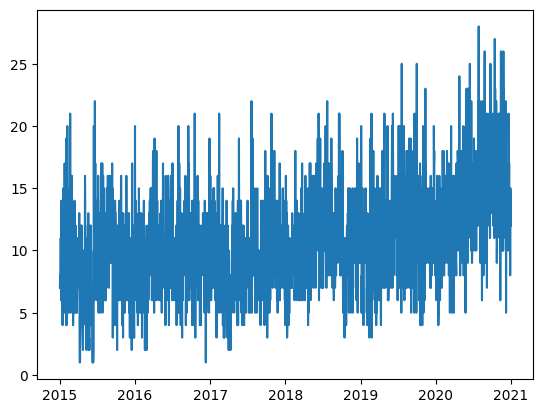

In [149]:
df['dates'] = pd.to_datetime(df['DateTime'])
time_counts = group_by_day(df = df, day_var="dates")
time_counts = time_counts.set_index(time_counts['date'])
plt.plot(time_counts['dcount'])
plt.show()